In [1]:
# file = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"

In [1]:
from fastai.vision.all import *
from fastai.optimizer import ranger

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
path = Path('/home/norbert/Documents/repos/engineerka/data/road/cropped')

path_im = path/'unlabeled'
path_lbl = path/'labeled'

In [3]:
lbl_names = get_image_files(path_lbl)
fnames = get_image_files(path_im)

In [4]:
fnames

(#67) [Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_300.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_52.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_405.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_16.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_12.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_294.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_61.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_42.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_22.png'),Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled/road_375.png')...]

In [5]:
lbl_names[5]

Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/labeled/road_294.png')

In [6]:
fn = 'road_32.png'

In [7]:
im = PILImage.create(f'{path_im}/{fn}')
msk = PILMask.create(f'{path_lbl}/road_32.png')

In [8]:
len(np.unique(msk))

2

In [9]:
np.unique(msk)

array([  0, 255], dtype=uint8)

In [10]:
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

In [11]:
p2c = n_codes(lbl_names)

In [12]:
p2c

{0: 0, 1: 255}

In [13]:
path_lbl

Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/labeled')

In [14]:
def get_msk(fn, p2c):
  "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
  fn = path_lbl/f'{fn.stem}{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

In [15]:
codes = ['lane', 'not lane']

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['not lane']
name2id

{'lane': 0, 'not lane': 1}

In [16]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [17]:
opt = ranger

In [18]:
get_y = lambda o: get_msk(o, p2c)

In [19]:
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   item_tfms=Resize(224),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])


# camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                #    get_items=get_image_files,
                #    splitter=FileSplitter(path/'valid.txt'),
                #    get_y=get_msk,
                #    batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [20]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [21]:
path_im

Path('/home/norbert/Documents/repos/engineerka/data/road/cropped/unlabeled')

In [22]:
dls = binary.dataloaders(path_im, bs=2)

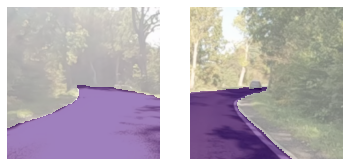

In [24]:
dls.show_batch(cmap='Purples', vmin=0, vmax=1)

In [25]:
# learn = unet_learner(dls, resnet34)
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)


/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/norbert/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# learn.lr_find()

In [26]:
# new 68 data images
learn.fit(8)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.399874,0.373783,0.999836,00:06
1,0.212994,0.133442,0.986543,00:04
2,0.152624,0.056226,0.989959,00:04
3,0.119321,0.112349,0.950574,00:04
4,0.132443,0.083679,0.984604,00:04
5,0.116579,0.050168,0.984772,00:03
6,0.092032,0.959772,0.991682,00:04
7,0.118813,0.072740,0.983792,00:04


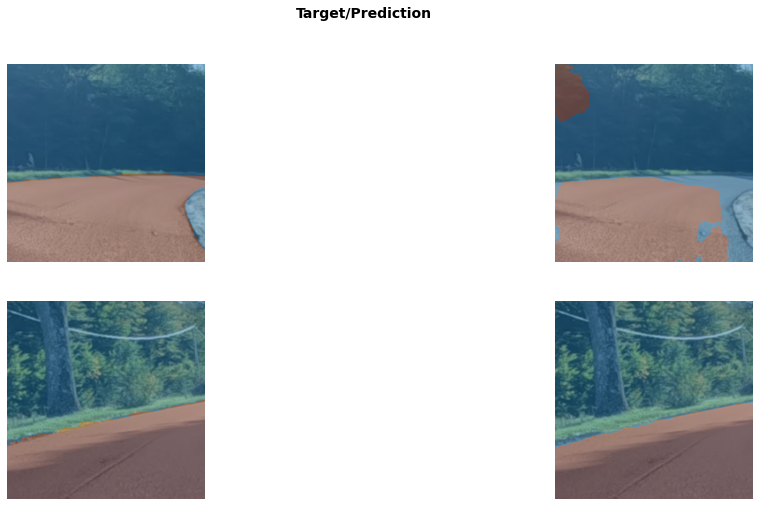

In [27]:
learn.show_results(max_n=4, figsize=(18,8))
# learn.summary()
# learn.lr_find()
# lr = 1e-3
# learn.fit_flat_cos(10, slice(lr))
# learn.save('stage-1')
# learn.load('stage-1');
# learn.show_results(max_n=4, figsize=(12,6))

In [29]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [29]:
learn.summary()

DynamicUnet (Input shape: 4 x 3 x 448 x 448)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 224 x 224  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 112 x 112  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [24]:
learn.load('stage-1')

/home/norbert/anaconda3/lib/python3.9/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [25]:
learn.recorder.plot_loss()

AttributeError: 'DynamicUnet' object has no attribute 'losses'